# Modeling Usage Example Notebook Updated

## Setup Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

from vtt.utils.helpers import set_seed
from vtt.data.caption_preprocessing import load_tokenizer, load_and_clean_captions
from vtt.data.image_preprocessing import load_features
from vtt.data.data_loader import load_split_datasets
from vtt.models.decoder import build_decoder_model
from vtt.models.train import train_model
from vtt.models.predict import display_images_with_captions, generate_caption_greedy
from vtt.visualization.history_plot import plot_training_history
from vtt.evaluation.evaluate import evaluate_model

2025-07-17 15:34:51.501031: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 15:34:51.912499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752780892.002345    1861 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752780892.028001    1861 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752780892.273321    1861 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Set Random Seed

In [3]:
# Set the random seed for tf, np, random, etc.
set_seed(42)

Random seed set to 42


## Paths

In [4]:
dataset_name = "flickr8k"
features_path = f"../data/processed/{dataset_name}_features.npz"
captions_path = f"../data/processed/{dataset_name}_padded_caption_sequences.npz"
tokenizer_path = f"../data/processed/{dataset_name}_tokenizer.json"
captions_file = f"../data/raw/{dataset_name}_captions.csv"

## Load Tokenizer and Features

In [5]:
tokenizer = load_tokenizer(tokenizer_path)
features = np.load(features_path)

[INFO] Tokenizer loaded from JSON file: ../data/processed/flickr8k_tokenizer.json


# Load Datasets

In [6]:
train_ds, val_ds, test_ds = load_split_datasets(
    features_path=features_path,
    captions_path=captions_path,
    batch_size=64,
    val_split=0.15,
    test_split=0.10,
    shuffle=True,
    buffer_size=1000,
    seed=42,
    cache=True,
    return_numpy=False
)


--- Dataset Split Sizes (number of individual samples) ---
Total samples loaded: 38008
Train samples: 28507
Validation samples: 5701
Test samples: 3800
----------------------------------------------------------



2025-07-17 15:35:49.475808: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Build Model

In [7]:
# Get max caption length from dataset
for (image_tensor, input_caption, _), _ in train_ds.take(1):
    max_caption_len = input_caption.shape[1]
# Get vocab size
vocab_size = tokenizer.num_words

model = build_decoder_model(vocab_size=vocab_size, max_caption_len=max_caption_len)
model.summary()

2025-07-17 15:37:41.061296: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-17 15:37:41.062488: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "ImageCaptionDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_image        │ (None, 1, 256)    │          0 │ image_dense[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_embedding   │ (None, 18, 256)   │  2,560,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_image_caption │ (None, 19, 256)   │          0 │ expand_image[0][… │
│ (Concatenate)       │                   │            │ caption_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 19, 512)   │  1,574,912 │ merge_image_capt… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 19, 10000) │  5,130,000 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trim_image_output   │ (None, 18, 10000) │          0 │ output_dense[0][… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,789,456 (37.34 MB)

 Trainable params: 9,789,456 (37.34 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [8]:
history = train_model(
    dataset=train_ds,
    model=model,
    epochs=1,
    val_dataset=val_ds,
    checkpoint_path=f"../models/tmp/{dataset_name}_decoder_weights.weights.h5",
    early_stop_patience=5,
)

2025-07-17 15:37:47.963182: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 3.7264
Epoch 1: val_loss improved from inf to 2.42168, saving model to ../models/tmp/flickr8k_decoder_weights.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 249s 556ms/step - loss: 3.7248 - val_loss: 2.4217
Restoring model weights from the end of the best epoch: 1.


## Plot Training History

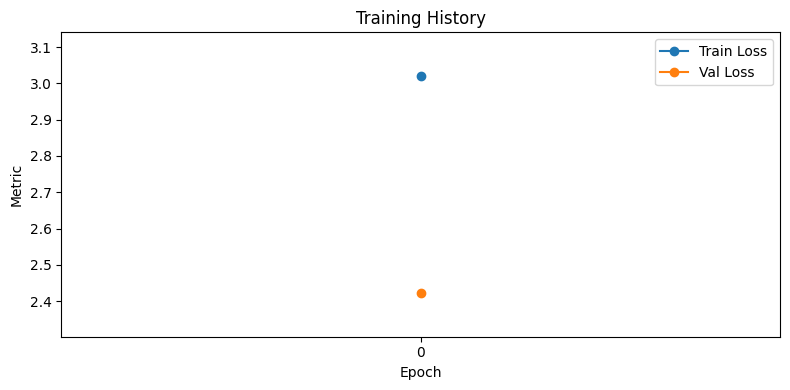

In [28]:
plot_training_history(history, metrics=["loss"])

## Save Model

In [10]:
model.save(f"../models/tmp/{dataset_name}_decoder_model.keras")

## Save Split Datasets

## Evaluate Model on Test Set

Note: This logic should probably be separated into a different notebook for model evaluation, where where the model, tokenizer, image_features, test_ds, etc. are loaded. It's here because it was convenient for debugging purposes with changes spanning multiple modules.

### This evaluates the entire test dataset

### This evaluates a small portion of the test dataset

In [15]:
# Rebatch test dataset into larger or smaller batches, depending on your system memory
# larger batches for faster inference (as long as you have enough memory)
new_batch_size = 32
batched_test_ds_for_eval = test_ds.unbatch().batch(new_batch_size).prefetch(tf.data.AUTOTUNE)

# Load captions into references dict
references_dict = load_and_clean_captions(f"../data/raw/{dataset_name}_captions.csv")

# Evaluate only a portion of the test dataset
num_batches_to_evaluate = 1
partial_test_ds_for_eval = batched_test_ds_for_eval.take(num_batches_to_evaluate)
print(f"\nEvaluating on a partial test set: {num_batches_to_evaluate} batches",
      f"(approx. {num_batches_to_evaluate * new_batch_size} samples)"
)

scores = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    features=features,
    test_dataset=partial_test_ds_for_eval,
    references_dict=references_dict,
    max_len=max_caption_len,
)

print("Evaluation Scores:")
for metric, score in scores.items():
    print(f"{metric}: {score:.4f}")


Evaluating on a partial test set: 1 batches (approx. 32 samples)
Note: Dataset size is unknown. Progress bar will not show total batches.


Generating Captions from Dataset: 0it [00:00, ?it/s]2025-07-17 15:56:08.084448: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Generating Captions from Dataset: 1it [00:31, 31.28s/it]2025-07-17 15:56:39.317270: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Generating Captions from Dataset: 1it [00:31, 31.29s/it]
/home/curtis/anaconda3/envs/northeastern/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new

Evaluation Scores:
BLEU-1: 0.4295
BLEU-2: 0.2338
BLEU-3: 0.1195
BLEU-4: 0.0715
METEOR: 0.2799
BERTScore_P: 0.8568
BERTScore_R: 0.8492
BERTScore_F1: 0.8529


## Predict Sample Captions

In [ ]:
image_folder = f"../../data/flickr8k_images/"
sample_image_ids = [
    "667626_18933d713e.jpg",
    "23445819_3a458716c1.jpg",
    "27782020_4dab210360.jpg",
    "35506150_cbdb630f4f.jpg",
    "47870024_73a4481f7d.jpg"
]

display_images_with_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder=image_folder
)